In [1]:
import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from metrics.query import DataFrameQuery
from common.utils import *
from metrics.utils import *

#from sklearn.feature_selection import mutual_info_regression MISSIN?
from dadapy.data import Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score, \
                                    adjusted_mutual_info_score
from scipy.stats import entropy
from sklearn.metrics import f1_score

from pathlib import Path
from functools import partial
from collections import Counter
import tqdm
import seaborn as sns
from common.config_plot import plot_config

In [2]:
df = pd.read_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/"
                    +"transposed_dataset/cluster_analysis/label_clustering_dataset.pkl")

In [2]:
def determine_shot(model):
    """ Determine the shot number based on model name. """
    return 4 if "70" in model else 5
def mutual_info(assignments, subjects):
    # Filter out unassigned points
    valid_indices = assignments != -1
    return mutual_info_score(assignments[valid_indices], subjects[valid_indices])

In [3]:
def compute_metrics(df):
    df_rows = []
    for row in df.iterrows():
        row = row[1]
        cluster_assignment_all = row["clusters_assignment"]
        n_layers = len(cluster_assignment_all)
        num_clusters = np.zeros(n_layers)
        num_assigned_points = np.zeros(n_layers)
        mean_cluster_size = np.zeros(n_layers)
        var_cluster_size = np.zeros(n_layers)
        entropy_values = np.zeros(n_layers)
        fraction_most_represented = np.zeros(n_layers)
        subjects_all = np.array(row["labels"])
        for i in range(n_layers):
            assignments = cluster_assignment_all[i]
            subjects = subjects_all[i]

            # Calculate cluster metrics
            valid_assignments = assignments[assignments != -1]
            unique_clusters, counts = np.unique(valid_assignments, return_counts=True)

            num_clusters[i] += len(unique_clusters)
            num_assigned_points[i] += len(valid_assignments)/len(assignments)
            mean_cluster_size[i] += np.mean(counts)
            var_cluster_size[i] += np.var(counts)
            # Entropy of the distribution of assignments
            # Fraction of the most represented class
            for cluster,count_cluster in zip(unique_clusters, counts):
                iter_subject = subjects[assignments == cluster]
                unique_sub, counts_sub = np.unique(iter_subject, return_counts=True)
                entropy_values[i] += entropy(counts_sub)*count_cluster
                if len(counts) > 0:
                    fraction_most_represented[i] += (np.max(counts_sub) / np.sum(counts_sub))*count_cluster
                else:
                    fraction_most_represented[i] += 0
                
            entropy_values[i] = entropy_values[i] / unique_clusters.shape[0]
            fraction_most_represented[i] =  fraction_most_represented[i] / unique_clusters.shape[0]
            
        df_rows.append([row["model"],
                    row["train_instances"],
                    num_clusters, 
                    num_assigned_points, 
                    mean_cluster_size, 
                    var_cluster_size, 
                    entropy_values, 
                    fraction_most_represented,
                    row["z"]])

    df_out = pd.DataFrame(df_rows, columns=["model", 
                                        "shot", 
                                        "num_clusters", 
                                        "num_assigned_points", 
                                        "mean_cluster_size", 
                                        "var_cluster_size", 
                                        "entropy_values", 
                                        "fraction_most_represented",
                                        "z"])
    return df_out



In [4]:
def tick_computer(n_layers, lenght):
    if n_layers < 50:
        tick_positions = np.arange(0, lenght, 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(0, lenght, 8)  # Generates positions 0, 4, 8, ...
    
    tick_labels = tick_positions +1 # Get the corresponding labels from x
    return tick_labels, tick_positions

In [5]:
def average_custom_blocks(y, n):
    if n == 0:
        return y
    # Initialize lists to store averages
    y_avg = []

    # Handle the first block [0:n]
    
    y_avg.append(np.mean(y[0:n]))
    
    # Handle the second block [0:n+1]
    if len(y) > n:
        
        y_avg.append(np.mean(y[0:n+1]))

    # Handle subsequent blocks [i:n+i] starting from i=1
    for i in range(1, len(y)-1):
        
        y_avg.append(np.mean(y[i:n+i+1]))
    assert len(y_avg) == len(y), f"y_avg:{len(y_avg)}, y:{len(y)}"

    return np.array(y_avg)

In [7]:
def plot_box(metrics, model):
    plt.figure()
    sns.set_style("whitegrid")
    metrics_0 = metrics.query(f"model=='{model}'" \
                              f"and shot==0")
    metrics_2 = metrics.query(f"model=='{model}'" \
                              f"and shot==2")
    metrics_5 = metrics.query(f"model=='{model}'" \
                              f"and shot=={determine_shot(model)}")


    n_layers = metrics_0["num_clusters"].values[0].shape[0]
    if "70" in model:
        n = 5
    else:
        n = 3
    
    if n_layers < 50:
        tick_positions = np.arange(1, n_layers, 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(1, n_layers, 8)  # Generates positions 0, 4, 8, ...
    
    tick_labels = tick_positions  # Get the corresponding labels from x
    print(n_layers)
    for n,ctx in enumerate(zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"]
                           )):
        plt.figure()
        sns.set_style("whitegrid")
        metrics_iter,label = ctx
        # CLUSTER SIZE DISTRIBUTION
        colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
        csd_data = []
        for i in range(n_layers):
            for _ in range(int(np.random.rand() * 10 + 10)):  # Random replication for illustrative purposes
                csd_data.append({
                    "Layer": f"Layer {i+1}",
                    "Cluster Size": np.random.normal(metrics_iter["mean_cluster_size"].values[0][i], np.sqrt(metrics_iter["var_cluster_size"].values[0][i]))
                })

        df = pd.DataFrame(csd_data)
        y=metrics_iter["fraction_most_represented"].values[0]
        layers = np.arange(n_layers)
        
        print(df["Cluster Size"].values)
        y_avg = average_custom_blocks(layers, df["Cluster Size"].values, n)
        df = pd.DataFrame({"Range of Layer": layers, "Cluster Size": y_avg})
        sns.boxplot(x='Range of Layer', y='Cluster Size', data=df, hue='Range of Layer', legend=False,palette="viridis")
        avg_metrics_iter_mean, avg_metrics_iter_var = average_custom_blocks(metrics_iter["mean_cluster_size"].values[0], metrics_iter["var_cluster_size"].values[0], n)
        avg_metrics_iter_var = np.sqrt(avg_metrics_iter_var)
        colors = plt.cm.viridis(np.linspace(0, 1, avg_metrics_iter_mean.shape[0]))
        for i,(mean,var) in enumerate(zip(avg_metrics_iter_mean, avg_metrics_iter_var)):
            plt.errorbar(i, mean, yerr=var, fmt='o-', color=colors[i])
        plt.title(f"Cluster Size Distribution {label}")
        plt.xlabel("Range of Layer")
        plt.ylabel("Mean +/- SD")
        plt.xticks(ticks=tick_positions, labels=tick_labels)
        plt.tick_params(axis='y')
        plt.legend()
        plt.savefig(f"plots_clustering/{model[11:][:-3]}-{label}-box.png")
        plt.tight_layout()
        plt.show()



In [18]:
def plot_metrics(metrics,models,title, avg_window):

    sns.set_style(
        "whitegrid",
        rc={"axes.edgecolor": ".15", "xtick.bottom": True, "ytick.left": True},
    )
    print(determine_shot(models[0]))
    metrics_0 = metrics.query(f"model=='{models[0]}'" \
                              f"and shot==0"\
                              f"and z==1.6")
    metrics_1 = metrics.query(f"model=='{models[0]}'" \
                              f"and shot==1"\
                              f"and z==1.6")
    metrics_2 = metrics.query(f"model=='{models[0]}'" \
                              f"and shot==2"\
                              f"and z==1.6")
    metrics_5 = metrics.query(f"model=='{models[0]}'" \
                              f"and shot=={determine_shot(models[0])}"\
                              f"and z==1.6")
    metrics_ft = metrics.query(f"model=='{models[1]}'" \
                               f"and shot==0"\
                               f"and z==1.6")
    # if "70" in models[0]:
    #     n = 5
    # else:
    #     n = 3
    
    plt.figure(dpi =200)
    figures = []    
    # avg_window = 2
    for metrics_iter,label, marker in zip([metrics_0,metrics_1,metrics_2,metrics_5, metrics_ft],
                            ["0 shot pt", "1 shot pt","2 shot pt", "5 shot pt", "0 shot ft"],
                            ["o","o","o","o","X"]
                           ):
        # # NUM CLUSTERS
        n_layers = int(metrics_iter["num_clusters"].values[0].shape[0])
        layers = np.arange(n_layers)
        y = metrics_iter["num_clusters"].values[0]
        print(f"avg before: {avg_window}")
        y_avg = average_custom_blocks(y, avg_window)
        print(f"avg after: {avg_window}")
        layers = layers[:-1]
        y_avg = y_avg[:-1]
        sns.lineplot(x=layers, y=y_avg, label = label)
        sns.scatterplot(x=layers, y=y_avg,marker=marker)
    if title:
        plt.title(title)
    
    plt.xlabel("Layer")
    plt.ylabel("Number of Clusters")
    tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels)
    plt.yticks(ticks =[i for i in range(10,90,10)] , labels = [i for i in range(10,90,10)])
    plt.tick_params(axis='y')
    plt.legend()
    
    plt.rcParams.update(plot_config)
    plt.tight_layout()
    # plt.savefig(f"dendogram/100/title_model/{models[0]}-num-cluster.pdf", format="pdf")
    
    plt.savefig(f"clustering_analysis{'/no_title' if not title else ''}/{models[0]}-num-cluster_avg_{avg_window}.pdf", format="pdf")
    plt.savefig(f"clustering_analysis{'/no_title' if not title else ''}/{models[0]}-num-cluster_avg_{avg_window}.png")
    # plt.savefig(f"dendogram/100/title_model/{models[0]}-num-cluster.png")
    #plt.savefig(f"dendogram/100/{models[0]}-num-cluster.png")

    plt.show()
    plt.close()    
        
    plt.figure(dpi =200)
    figures = []    
    
    for metrics_iter,label, marker in zip([metrics_0,metrics_1,metrics_2,metrics_5, metrics_ft],
                            ["0 shot pt", "1 shot pt","2 shot pt", "5 shot pt", "0 shot ft"],
                            ["o","o","o","o","X"]
                           ):
        #NUM ASSIGNED POINTS
        # Reshape x and y to have 'n' elements per row, ignoring the remainder
        n_layers = int(metrics_iter["num_clusters"].values[0].shape[0])
        layers = np.arange(n_layers)
        y=metrics_iter["num_assigned_points"].values[0]
        y_avg = average_custom_blocks(y, avg_window)
        layers = layers[:-1]
        y_avg = y_avg[:-1]
 
        sns.lineplot(x=layers, y=y_avg, label = label)
        sns.scatterplot(x=layers, y=y_avg, marker=marker)
    # plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("Core points fraction")
    tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels)
    plt.yticks(ticks =np.arange(0,0.8,0.1).round(3) , labels = np.arange(0,0.8,0.1).round(3))
    if title:
        plt.title(title)
    #plt.ylim(0,0.7)
    plt.legend()
    plt.rcParams.update(plot_config)
    plt.tight_layout()
    print(f"{avg_window=}")
    # plt.savefig(f"dendogram/100/title_model/{models[0]}-num-ass-point.pdf", format = "pdf")
    plt.savefig(f"clustering_analysis{'/no_title' if not title else ''}/{models[0]}-num-ass-point_avg_{avg_window}.pdf", format="pdf")
    plt.savefig(f"clustering_analysis{'/no_title' if not title else ''}/{models[0]}-num-ass-point_avg_{avg_window}.png")
    # plt.savefig(f"cluclustering_analysis/{models[0]}-num-ass-point_avg_{n}.pdf", format = "pdf")
    # plt.savefig(f"dendogram/100/title_model/{models[0]}-num-ass-point.png")
    # plt.savefig(f"dendogram/100/{models[0]}-num-ass-point.png")
    plt.show()
    plt.close()    
        
    # plt.figure(figsize=(conf_size.width, conf_size.height))
    # figures = []    
    # for metrics_iter,label, marker in zip([metrics_0,metrics_2,metrics_5],
    #                         ["0shot", "2shot", "5shot"],
    #                         ["o","o","X"]
    #                        ):
    #     sns.set_style("whitegrid")
        
    #     y=metrics_iter["entropy_values"].values[0]
    #     x_avg, y_avg = average_custom_blocks(layers, y, n)
    #     sns.lineplot(x = x_avg, y = y_avg, label = label, linewidth = conf_size.linewidth)
    #     sns.scatterplot(x = x_avg, y = y_avg, marker=marker,s = conf_size.s)
    # plt.title("Entropy of Cluster Distribution", fontsize=conf_size.title)
    # plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
    # plt.ylabel("Entropy", fontsize=conf_size.ylabel)
    # tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    # plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
    # plt.yticks(ticks =[i for i in range(100,500,100)] , labels = [i for i in range(100,500,100)], fontsize = conf_size.xticks)
    # plt.legend(fontsize=conf_size.legend)
    # plt.tight_layout()
    # plt.savefig(f"dendogram/100/{model[11:][:-3]}-entropy.png")
    # plt.show()
    
    # plt.figure(figsize=(conf_size.width, conf_size.height))
    # figures = []    
    # for metrics_iter, label, marker in zip([metrics_0,metrics_2,metrics_5],
    #                         ["0shot", "2shot", "5shot"],
    #                         ["o","o","X"]
    #                        ):    
    #     sns.set_style("whitegrid")
    #     y=metrics_iter["fraction_most_represented"].values[0]
    #     x_avg, y_avg = average_custom_blocks(layers, y, n)
    #     sns.lineplot(x = x_avg, y = y_avg, label = label, linewidth = conf_size.linewidth)
    #     sns.scatterplot(x = x_avg, y = y_avg, marker=marker, s = conf_size.s)
    # plt.title("Fraction of Most Represented Class", fontsize=conf_size.title)
    # plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
    # plt.ylabel("Fraction", fontsize=conf_size.ylabel)
    # tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    # plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
    # plt.yticks(ticks =[i for i in range(30,80,10)] , labels = [i for i in range(30,80,10)], fontsize = conf_size.xticks)
    # plt.tick_params(axis='y', labelsize=conf_size.yticks)
    # plt.legend(fontsize=21)
    # plt.tight_layout()
    # plt.savefig(f"dendogram/100/{model[11:][:-3]}-frac_most_repr.png")
    # plt.show()
    



    

In [ ]:

model2_7b = ["llama-2-7b", "llama-2-7b-ft"]
model2_13b = ["llama-2-13b","llama-2-13b-ft"]
model2_70b = ["llama-2-70b", "llama-2-70b-chat"]
model3_8b = ["llama-3-8b","llama-3-8b-ft"]
model3_70b = ["llama-3-70b", "llama-3-70b-chat"]
model_mistral = ["mistral-1-7b", "mistral-1-7b-ft"]

models = [model2_7b, 
          model2_13b,
          model2_70b,
          model3_8b, 
          model3_70b,
          model_mistral]

n = 2    
# metrics = compute_metrics(df)
for n, ctx  in enumerate(zip(models,[f"Llama 2 7b", 
                                    f"Llama 2 13b", 
                                    f"Llama 2 70b",
                                    f"Llama 3 8b", 
                                    f"Llama 3 70b",
                                    f"Mistral 7b"])):
    model_iter, title = ctx
    plot_metrics(metrics,model_iter, title = None, avg_window = 3)
    #plot_box(metrics, model)

# Non avg

In [ ]:
def plot_box(metrics, model):
    plt.figure(figsize=(conf_size.width, conf_size.height))
    sns.set_style("whitegrid")
    metrics_0 = metrics.query(f"model=='{model}'" \
                              f"and shot==0")
    metrics_2 = metrics.query(f"model=='{model}'" \
                              f"and shot==2")
    metrics_5 = metrics.query(f"model=='{model}'" \
                              f"and shot=={determine_shot(model)}")


    n_layers = metrics_0["num_clusters"].values[0].shape[0]
    if "70" in model:
        n = 5
    else:
        n = 3
    
    if n_layers < 50:
        tick_positions = np.arange(1, n_layers, 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(1, n_layers, 8)  # Generates positions 0, 4, 8, ...
    
    tick_labels = tick_positions  # Get the corresponding labels from x
    print(n_layers)
    for n,ctx in enumerate(zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"]
                           )):
        plt.figure(figsize=(conf_size.width, conf_size.height))
        sns.set_style("whitegrid")
        metrics_iter,label = ctx
        # CLUSTER SIZE DISTRIBUTION
        colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
        csd_data = []
        for i in range(n_layers):
            for _ in range(int(np.random.rand() * 10 + 10)):  # Random replication for illustrative purposes
                csd_data.append({
                    "Layer": f"Layer {i+1}",
                    "Cluster Size": np.random.normal(metrics_iter["mean_cluster_size"].values[0][i], np.sqrt(metrics_iter["var_cluster_size"].values[0][i]))
                })

        df = pd.DataFrame(csd_data)
        y=metrics_iter["fraction_most_represented"].values[0]
        layers = np.array(range(n_layers))
        x_avg, y_avg = average_custom_blocks(layers, df["Cluster Size"].values, n)
        df = pd.DataFrame({"Range of Layer": x_avg, "Cluster Size": y_avg})
        sns.boxplot(x='Range of Layer', y='Cluster Size', data=df, hue='Range of Layer', legend=False,palette="viridis")
        avg_metrics_iter_mean, avg_metrics_iter_var = average_custom_blocks(metrics_iter["mean_cluster_size"].values[0], metrics_iter["var_cluster_size"].values[0], n)
        avg_metrics_iter_var = np.sqrt(avg_metrics_iter_var)
        colors = plt.cm.viridis(np.linspace(0, 1, avg_metrics_iter_mean.shape[0]))
        for i,(mean,var) in enumerate(zip(avg_metrics_iter_mean, avg_metrics_iter_var)):
            plt.errorbar(i, mean, yerr=var, fmt='o-', color=colors[i])
        plt.title(f"Cluster Size Distribution {label}", fontsize=conf_size.title)
        plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
        plt.ylabel("Mean +/- SD", fontsize=conf_size.ylabel)
        plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
        plt.tick_params(axis='y', labelsize=conf_size.yticks)
        plt.legend(fontsize=conf_size.legend)
        plt.savefig(f"plots_clustering/{model[11:][:-3]}-{label}-box.png")
        plt.tight_layout()
        plt.show()



# Questions sampled 13

In [24]:
def plot_metrics(metrics_data, 
                 metrics_data_concat, 
                 models, 
                 title, 
                 avg_window):
    metrics = []
    metrics_concat = []

    
    for shot in ['0', determine_shot(models[0])]:
        metrics_iter = metrics_data.query(f"model=='{models[0]}'" \
                                          f"and shot=={shot}"\
                                          f"and z==1.6")
        metrics.append(metrics_iter)
    metrics_iter = metrics_data.query(f"model=='{models[1]}'" \
                                       f"and shot==0"\
                                       f"and z==1.6")
    print(metrics_iter)
    metrics.append(metrics_iter)

    for shot in ['0', determine_shot(models[0])]:
        metrics_iter = metrics_data_concat.query(f"model=='{models[0]}'" \
                                                 f"and shot=={shot}"\
                                                 f"and z==1.6")
        metrics_concat.append(metrics_iter)
    metrics_iter = metrics_data_concat.query(f"model=='{models[1]}'" \
                       f"and shot==0"\
                       f"and z==1.6")
    metrics_concat.append(metrics_iter)
    
    # Set up the plot
    sns.set_style(
        "whitegrid",
        rc={"axes.edgecolor": ".15", "xtick.bottom": True, "ytick.left": True},
    )
    plt.figure()
    n_layers = int(metrics[0]["num_clusters"].values[0].shape[0])
    y = metrics[0]["num_clusters"].values[0]
    # Plot function for num clusters
    def plot_num_clusters(is_concat=False):
        if is_concat:
            concat = "_concat"
            metrics_foo = metrics_concat
        else:
            concat = ""
            metrics_foo = metrics
        for metrics_iter,label, marker in zip(metrics_foo,
                                ["0 shot pt"+concat, "5 shot pt"+concat, "0 shot ft"+concat],
                                ["o","o","X"]
                            ):
            # # NUM CLUSTERS
            n_layers = int(metrics_iter["num_clusters"].values[0].shape[0])
            layers = np.arange(n_layers)
            y = metrics_iter["num_clusters"].values[0]
            y_avg = average_custom_blocks(y, avg_window)
            layers = layers[:-1]
            y_avg = y_avg[:-1]
            sns.lineplot(x=layers, y=y_avg, label = label)
            sns.scatterplot(x=layers, y=y_avg,marker=marker)

    plot_num_clusters()
    plot_num_clusters(is_concat=True)
    if title:
        plt.title(title)
    
    plt.xlabel("Layer")
    plt.ylabel("Number of Clusters")
    tick_labels, tick_positions = tick_computer(n_layers, y.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels)
    #plt.yticks(ticks =[i for i in range(10,90,10)] , labels = [i for i in range(10,90,10)])
    plt.tick_params(axis='y')
    plt.legend()
    
    plt.rcParams.update(plot_config)
    plt.tight_layout()
    plt.savefig(f"clustering_analysis/13prompt{'/no_title' if not title else ''}/"
                f"{models[0]}-num-cluster_avg_{avg_window}.pdf", format="pdf")
    plt.savefig(f"clustering_analysis/13prompt{'/no_title' if not title else ''}/"
                f"{models[0]}-num-cluster_avg_{avg_window}.png")


    plt.show()
    plt.close()    
        
    # -------------------------------------------------------------------
    # -------------------------------------------------------------------
    plt.figure()
    n_layers = int(metrics[0]["num_clusters"].values[0].shape[0])
    y = metrics[0]["num_clusters"].values[0]
    def num_assinged_points(is_concat=False):
        if is_concat:
            concat = "_concat"
            metrics_foo = metrics_concat
        else:
            concat = ""
            metrics_foo = metrics
        for metrics_iter,label, marker in zip(metrics_foo,
                                ["0 shot pt"+concat, "5 shot pt"+concat, "0 shot ft"+concat],
                                ["o","o","X"]
                            ):
            #NUM ASSIGNED POINTS
            # Reshape x and y to have 'n' elements per row, ignoring the remainder
            n_layers = int(metrics_iter["num_clusters"].values[0].shape[0])
            layers = np.arange(n_layers)
            y=metrics_iter["num_assigned_points"].values[0]
            y_avg = average_custom_blocks(y, avg_window)
            layers = layers[:-1]
            y_avg = y_avg[:-1]
    
            sns.lineplot(x=layers, y=y_avg, label = label)
            sns.scatterplot(x=layers, y=y_avg, marker=marker)
    num_assinged_points()
    num_assinged_points(is_concat=True)   
    
    plt.xlabel("Layer")
    plt.ylabel("Core points fraction")
    tick_labels, tick_positions = tick_computer(n_layers, y.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels)
    #plt.yticks(ticks =np.arange(0,0.8,0.1).round(3) , labels = np.arange(0,0.8,0.1).round(3))
    if title:
        plt.title(title)
    plt.legend()
    plt.rcParams.update(plot_config)
    plt.tight_layout()
   
    plt.savefig(f"clustering_analysis/13prompt{'/no_title' if not title else ''}/"
                f"{models[0]}-num-ass-point_avg_{avg_window}.pdf", format="pdf")
    plt.savefig(f"clustering_analysis/13prompt{'/no_title' if not title else ''}/"
                f"{models[0]}-num-ass-point_avg_{avg_window}.png")
    
    plt.show()
    plt.close()    
            
    

            model  shot                                       num_clusters  \
23  llama-3-8b-ft     0  [22.0, 32.0, 34.0, 34.0, 34.0, 33.0, 36.0, 32....   

                                  num_assigned_points  \
23  [0.1669576604103012, 0.17721518987341772, 0.14...   

                                    mean_cluster_size  \
23  [69.54545454545455, 50.75, 40.14705882352941, ...   

                                     var_cluster_size  \
23  [3197.884297520661, 2588.1875, 1974.1254325259...   

                                       entropy_values  \
23  [81.57957455483391, 35.77020694546178, 16.9279...   

                            fraction_most_represented    z  
23  [39.90909090909091, 36.0625, 33.76470588235294...  1.6  


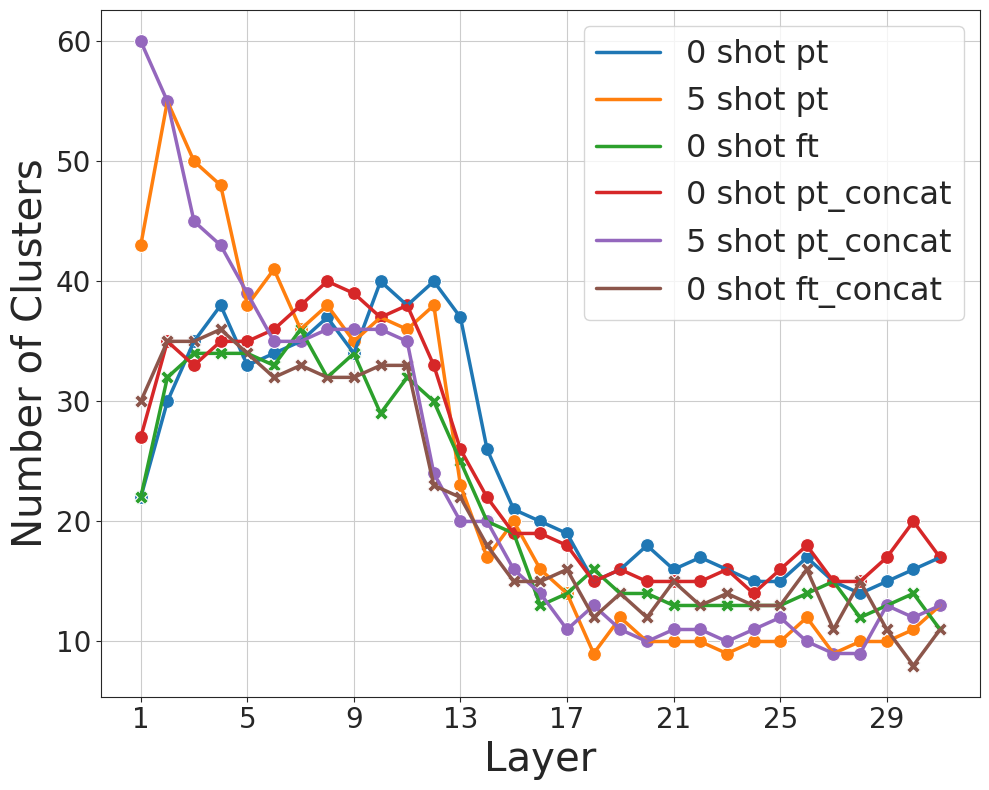

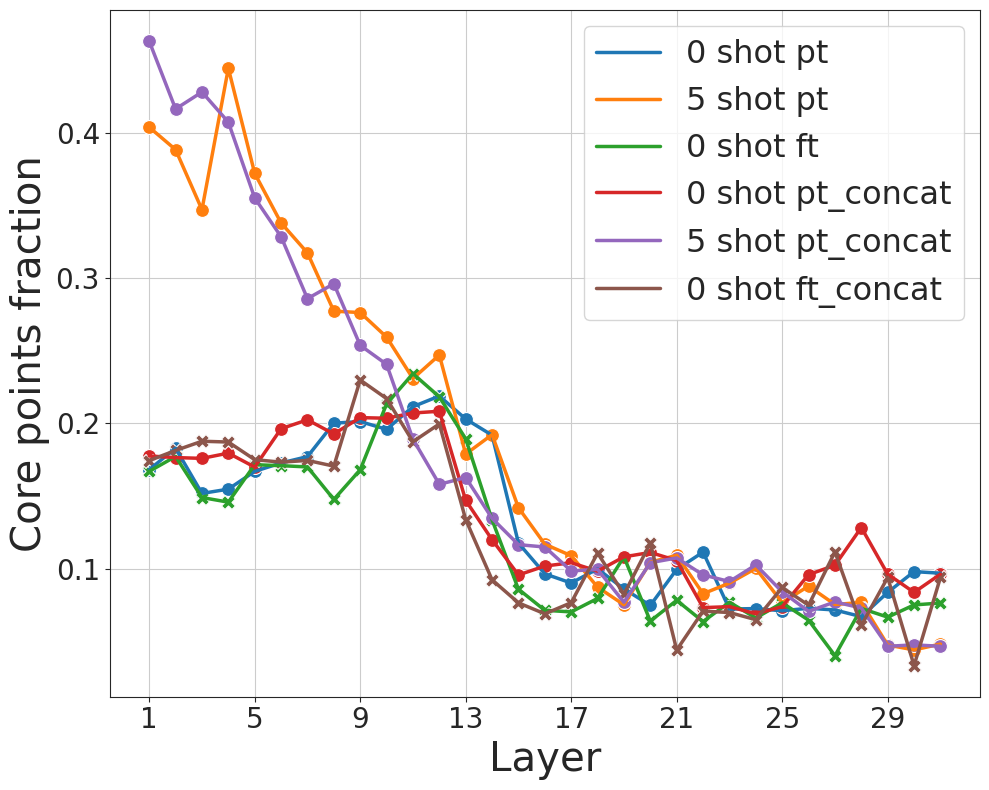

In [25]:
df_13_reg = pd.read_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/"
                    +"transposed_dataset/13prompt_halo/label_clustering_dataset.pkl")

df_13_reg.model = df_13_reg.model.apply(lambda x: x.replace("meta-llama-Llama-3-8b-hf", "llama-3-8b"))
df_13_reg.model = df_13_reg.model.apply(lambda x: x.replace("meta-llama-Llama-3-8b-ft-hf", "llama-3-8b-ft"))

df_13_concat = pd.read_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/"
                    +"transposed_dataset/13prompt_halo_concat/label_clustering_dataset.pkl")
df_13_concat.model = df_13_concat.model.apply(lambda x: x.replace("meta-llama-Llama-3-8b-hf", "llama-3-8b"))
df_13_concat.model = df_13_concat.model.apply(lambda x: x.replace("meta-llama-Llama-3-8b-ft-hf", "llama-3-8b-ft"))

model3_8b = ["llama-3-8b","llama-3-8b-ft"]

models = [model3_8b]

n = 2    
if 'metrics' not in globals() and 'metrics_concat' not in globals():
    metrics = compute_metrics(df_13_reg)
    metrics_concat = compute_metrics(df_13_concat)

for n, ctx  in enumerate(zip(models,[f"Llama 3 8b"])):
    model_iter, title = ctx
    plot_metrics(metrics,
                 metrics_concat,
                 models=model_iter,
                 title = None, 
                 avg_window = 0)
    #plot_box(metrics, model)